# Variational Autoencoders on Anime Faces

This model will train a Variational Autoencoder (VAE) using the [anime faces dataset by MckInsey666](https://github.com/bchao1/Anime-Face-Dataset). 

# Package

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np
import os, zipfile, urllib.request, random
from IPython import display

In [2]:
# set a random seed
np.random.seed(51)

# parameters for building the model and training
BATCH_SIZE=2000
LATENT_DIM=512
IMAGE_SIZE=64

### download images

In [3]:
try:
    os.mkdir('./anima_imgs')
except OSError:
    pass 
    
data_url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Resources/anime-faces.zip"
data_file_name = "animefaces.zip"
download_dir = './anima_imgs/'
urllib.request.urlretrieve(data_url, data_file_name)

# extract the zip file
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()

### format images

In [8]:
def get_dataset_slice_paths(img_dir):
    image_file_list = os.listdir(img_dir)
    image_paths = [os.path.join(img_dir, image_file) for image_file in image_file_list]
    
    return image_paths

def format_image(image_filename):
    img_raw = tf.io.read_file(image_filename)
    image = tf.image.decode_jpeg(img_raw)
    
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.
    image = tf.reshape(image, shape=(IMAGE_SIZE, IMAGE_SIZE, 3, ))
    
    return image

In [10]:
paths = get_dataset_slice_paths("./anime_imgs/images/")

# shuffle the paths
random.shuffle(paths)

# split the paths list into to training (80%) and validation sets(20%).
paths_len = len(paths)
train_paths_len = int(paths_len * 0.8)

train_paths = paths[:train_paths_len]
val_paths = paths[train_paths_len:]

# load the training image paths into tensors, create batches and shuffle
training_dataset = tf.data.Dataset.from_tensor_slices((train_paths))
training_dataset_batches = training_dataset.map(format_image).shuffle(1000).batch(BATCH_SIZE)

# load the validation image paths into tensors and create batches
validation_dataset = tf.data.Dataset.from_tensor_slices((val_paths))
validation_dataset_batches = validation_dataset.map(format_image).batch(BATCH_SIZE)

print(f'number of batches in the training set: {len(training_dataset_batches)}')
print(f'number of batches in the validation set: {len(validation_dataset_batches)}')

number of batches in the training set: 26
number of batches in the validation set: 7


## Display Utilities

help in visualizing the data.

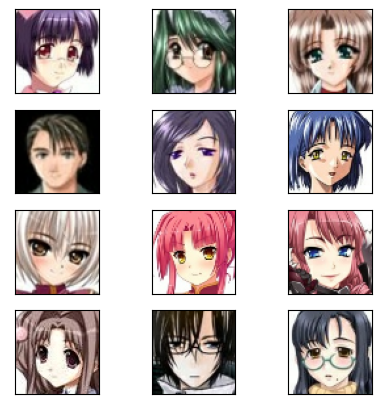

In [16]:
# display some sample img from dataset_batches
def display_faces(dataset, size=9):
    '''Takes a sample from a dataset batch and plots it in a grid.'''
    dataset = dataset.unbatch().take(size)
    n_cols = 3
    n_rows = size // n_cols
    plt.figure(figsize=(5, 5))
    
    for i, image in enumerate(dataset):
        disp_img = np.reshape(image, (64,64,3))
        plt.subplot(n_rows, n_cols, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(disp_img)
        
display_faces(validation_dataset_batches, size=12)

# Build the Model
<img src="imgs/vae_overview.png" width="60%" height="60%"/>

In [17]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        """Generates a random sample and combines with the encoder output
        
        Args:
          inputs -- output tensor from the encoder
    
        Returns:
          `inputs` tensors combined with a random sample
        """
        ### START CODE HERE ###
        mu, sigma = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        z = mu + tf.exp(0.5 * sigma) * epsilon
        ### END CODE HERE ###
        return  z

In [18]:
def encoder_layers(inputs, latent_dim):
    """Defines the encoder's layers.
    Args:
      inputs -- batch from the dataset
      latent_dim -- dimensionality of the latent space
  
    Returns:
      mu -- learned mean
      sigma -- learned standard deviation
      batch_3.shape -- shape of the features before flattening
    """
    ### START CODE HERE ###
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same", activation='relu', name="encode_conv1")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same", activation='relu', name="encode_conv2")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding="same", activation='relu', name="encode_conv3")(x)
    batch_3 = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Flatten(name="encode_flatten")(batch_3)
    
    x = tf.keras.layers.Dense(1024, activation='relu', name="encode_dense")(x)
    x = tf.keras.layers.BatchNormalization()(x)
  
    mu = tf.keras.layers.Dense(latent_dim, name='latent_mu')(x)
    sigma = tf.keras.layers.Dense(latent_dim, name ='latent_sigma')(x)  
    
    ### END CODE HERE ###
  
    # revise `batch_3.shape` here if you opted not to use 3 Conv2D layers
    return mu, sigma, batch_3.shape

In [19]:
def encoder_model(latent_dim, input_shape):
    """Defines the encoder model with the Sampling layer
    Args:
      latent_dim -- dimensionality of the latent space
      input_shape -- shape of the dataset batch
  
    Returns:
      model -- the encoder model
      conv_shape -- shape of the features before flattening
    """
    ### START CODE HERE ###
    inputs = tf.keras.layers.Input(shape=input_shape)
    mu, sigma, conv_shape = encoder_layers(inputs, latent_dim=LATENT_DIM)
    z = Sampling()((mu, sigma))
    model = tf.keras.Model(inputs = inputs, outputs= [mu, sigma, z])
    ### END CODE HERE ###
    model.summary()
    return model, conv_shape

In [20]:
def decoder_layers(inputs, conv_shape):
    """Defines the decoder layers.
    Args:
      inputs -- output of the encoder 
      conv_shape -- shape of the features before flattening
  
    Returns:
      tensor containing the decoded output
    """
    ### START CODE HERE ###
    units = conv_shape[1] * conv_shape[2] * conv_shape[3]
    x = tf.keras.layers.Dense(units, activation = 'relu', name="decode_dense1")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), name="decode_reshape")(x)
  
    x = tf.keras.layers.Conv2DTranspose(128, kernel_size=3, strides = 2, padding='same', activation='relu', name="decode_conv2d_1")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides = 2, padding='same', activation='relu', name="decode_conv2d_2")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides = 2, padding='same', activation='relu', name="decode_conv2d_3")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(3, kernel_size=3, strides = 1, padding='same', activation='sigmoid', name="decode_final")(x)
    
    ### END CODE HERE ###
    return x

In [21]:
def decoder_model(latent_dim, conv_shape):
    """Defines the decoder model.
    Args:
      latent_dim -- dimensionality of the latent space
      conv_shape -- shape of the features before flattening
  
    Returns:
      model -- the decoder model
    """
    ### START CODE HERE ###
    inputs = tf.keras.layers.Input(shape=(latent_dim,))
    outputs = decoder_layers(inputs, conv_shape)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    ### END CODE HERE ###
    model.summary()
    return model

In [22]:
def kl_reconstruction_loss(inputs, outputs, mu, sigma):
    """ Computes the Kullback-Leibler Divergence (KLD)
    Args:
      inputs -- batch from the dataset
      outputs -- output of the Sampling layer
      mu -- mean
      sigma -- standard deviation
  
    Returns:
      KLD loss
    """
    kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
    return tf.reduce_mean(kl_loss) * -0.5

In [23]:
def vae_model(encoder, decoder, input_shape):
    """Defines the VAE model
    Args:
      encoder -- the encoder model
      decoder -- the decoder model
      input_shape -- shape of the dataset batch
  
    Returns:
      the complete VAE model
    """
    ### START CODE HERE ###
    inputs = tf.keras.Input(shape=input_shape)
    mu, sigma, z = encoder(inputs)
    reconstructed = decoder(z)
    
    model = tf.keras.Model(inputs=inputs, outputs=reconstructed)
    loss = kl_reconstruction_loss(inputs, z, mu, sigma)
    model.add_loss(loss)
    ### END CODE HERE ###
    return model

In [24]:
def get_models(input_shape, latent_dim):
    """Returns the encoder, decoder, and vae models"""
    ### START CODE HERE ###
    encoder, conv_shape = encoder_model(latent_dim=latent_dim, input_shape=input_shape)
    decoder = decoder_model(latent_dim=latent_dim, conv_shape=conv_shape)
    vae = vae_model(encoder, decoder, input_shape=input_shape)
    
    ### END CODE HERE ###
    return encoder, decoder, vae

In [28]:
encoder, decoder, vae = get_models(input_shape=(64,64,3,), latent_dim=LATENT_DIM)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 encode_conv1 (Conv2D)          (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['encode_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 encode_conv2 (Conv2D)          (None, 16, 16, 64)   18496       ['batch_normalization[0][0]']

In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
loss_metric = tf.keras.metrics.Mean()
mse_loss = tf.keras.losses.MeanSquaredError()
bce_loss = tf.keras.losses.BinaryCrossentropy()

In [26]:
def generate_and_save_images(model, epoch, step, test_input):
    """Helper function to plot our 16 images
  
    Args:
  
    model -- the decoder model
    epoch -- current epoch number during training
    step -- current step number during training
    test_input -- random tensor with shape (16, LATENT_DIM)
    """
  
    # generate images from the test input
    predictions = model.predict(test_input)
  
    # plot the results
    fig = plt.figure(figsize=(4,4))
  
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
  
    # tight_layout minimizes the overlap between 2 sub-plots
    fig.suptitle("epoch: {}, step: {}".format(epoch, step))
    plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
    plt.show()

In [27]:
# # Training loop. Display generated images each epoch

# ### START CODE HERE ###
# epochs = 20
# ### END CODE HERE ###

# random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])
# generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

# for epoch in range(epochs):
#     print('Start of epoch %d' % (epoch,))

#   # Iterate over the batches of the dataset.
#     for step, x_batch_train in enumerate(training_dataset):
#         with tf.GradientTape() as tape:

#             reconstructed = vae(x_batch_train)
#             # Compute reconstruction loss
#             flattened_inputs = tf.reshape(x_batch_train, shape=[-1])
#             flattened_outputs = tf.reshape(reconstructed, shape=[-1])
#             loss = mse_loss(flattened_inputs, flattened_outputs) * (64 * 64 * 3)
#             loss += sum(vae.losses)  
      
      
#         grads = tape.gradient(loss, vae.trainable_weights)

#         optimizer.apply_gradients(zip(grads, vae.trainable_weights))
#     ### END CODE HERE
    
#         loss_metric(loss)

#         if step % 10 == 0:
#             display.clear_output(wait=False)    
#         generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
#         print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))

In [29]:
vae.load_weights('./saved_weights/vae_anime_weights.h5')
decoder.load_weights('./saved_weights/vae_anime_decoder_weights.h5')

In [34]:
def display_one_row(disp_images, offset, shape=(28, 28)):
    '''Displays a row of images.'''
    for idx, image in enumerate(disp_images):
        plt.subplot(2, 10, offset + idx + 1)
        plt.xticks([])
        plt.yticks([])
        image = np.reshape(image, shape)
        plt.imshow(image)


def display_results(disp_input_images, disp_predicted):
    '''Displays input and predicted images.'''
    plt.figure(figsize=(15, 5))
    display_one_row(disp_input_images, 0, shape=(IMAGE_SIZE,IMAGE_SIZE,3))
    display_one_row(disp_predicted, 10, shape=(IMAGE_SIZE,IMAGE_SIZE,3))

1/1 [==============================] - 1s 522ms/step


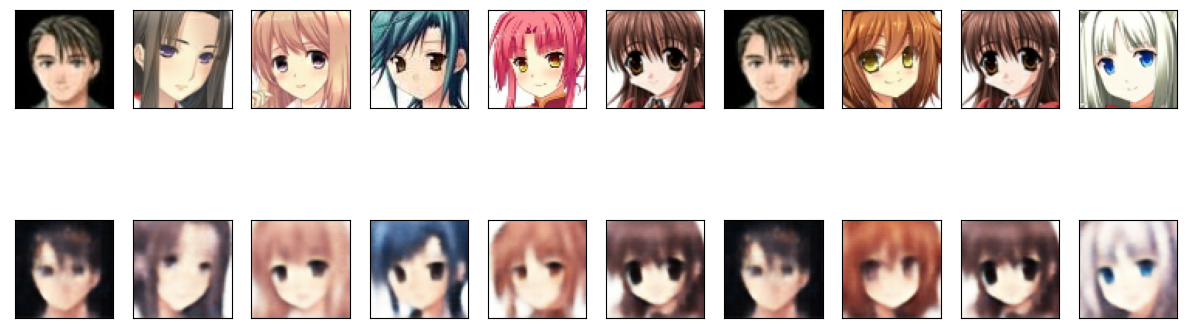

In [36]:
test_dataset = validation_dataset_batches.take(1)
output_samples = []

for input_image in tfds.as_numpy(test_dataset):
      output_samples = input_image

idxs = np.random.choice(64, size=10)

vae_predicted = vae.predict(test_dataset)
display_results(output_samples[idxs], vae_predicted[idxs])
plt.savefig('./imgs/anime_reconstructed.jpg')